Step 3: Customer Segmentation Using RFM Analysis 

Subtask 1: Calculate RFM Metrics

1.1 Define the RFM Metrics

Recency (R): Days since the last purchase.
Frequency (F): Total number of purchases.
Monetary (M): Total revenue spent by the customer.

1.2 Choose a Reference Date

In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv("cleaned_ecommerce_sales.csv")
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Reference date: one day after the last order date
reference_date = df['Order Date'].max() + pd.Timedelta(days=1)
print("Reference Date for Recency Calculation:", reference_date.date())


Reference Date for Recency Calculation: 2025-10-04


1.3 Group Data by Customer

In [2]:
# Aggregate data for RFM
rfm_df = df.groupby('Customer Name').agg({
    'Order Date': lambda x: (reference_date - x.max()).days,  # Recency
    'Order ID': 'count',                                      # Frequency
    'Sales': 'sum'                                           # Monetary
}).reset_index()

# Rename columns
rfm_df.rename(columns={'Order Date': 'Recency', 'Order ID': 'Frequency', 'Sales': 'Monetary'}, inplace=True)

print("\nSample RFM table:")
print(rfm_df.head())



Sample RFM table:
           Customer Name  Recency  Frequency  Monetary
0  Aaina Balasubramanian      643          1  158876.8
1         Aaina Bhargava       15          1   26411.9
2              Aaina Bir      133          1  231044.0
3          Aaina Chander      286          1  350240.0
4         Aaina Chandran      572          1   43747.5


1.4 Assign RFM Scores (1-5)

In [3]:
# Recency score: 5 = recent purchase
rfm_df['R_Score'] = pd.qcut(rfm_df['Recency'], 5, labels=[5,4,3,2,1]).astype(int)

# Frequency score: 5 = most frequent
rfm_df['F_Score'] = pd.qcut(rfm_df['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)

# Monetary score: 5 = highest spending
rfm_df['M_Score'] = pd.qcut(rfm_df['Monetary'], 5, labels=[1,2,3,4,5]).astype(int)

# Combine RFM score
rfm_df['RFM_Segment'] = rfm_df['R_Score'].astype(str) + '-' + rfm_df['F_Score'].astype(str) + '-' + rfm_df['M_Score'].astype(str)

print("\nSample RFM Segments:")
print(rfm_df[['Customer Name','Recency','Frequency','Monetary','RFM_Segment']].head())



Sample RFM Segments:
           Customer Name  Recency  Frequency  Monetary RFM_Segment
0  Aaina Balasubramanian      643          1  158876.8       1-1-4
1         Aaina Bhargava       15          1   26411.9       5-1-1
2              Aaina Bir      133          1  231044.0       5-1-5
3          Aaina Chander      286          1  350240.0       4-1-5
4         Aaina Chandran      572          1   43747.5       2-1-2


1.5 Interpret RFM Segments

In [4]:
# Count customers in each RFM segment
segment_counts = rfm_df['RFM_Segment'].value_counts().reset_index()
segment_counts.columns = ['RFM_Segment','Customer_Count']

print("\nRFM Segment Counts:")
print(segment_counts.head(10))



RFM Segment Counts:
  RFM_Segment  Customer_Count
0       5-5-5              63
1       2-3-4              56
2       4-5-2              54
3       4-5-5              53
4       3-1-2              51
5       2-4-4              51
6       1-3-1              50
7       5-1-1              49
8       3-1-5              49
9       1-2-4              49


1.6 Key Insights & Recommendations

High-Value Customers (5-5-5): Offer loyalty programs, exclusive deals, early access to sales.
Potential Loyalists (4-4-5): Nurture through personalized recommendations & targeted promotions.
At-Risk Customers (3-2-2): Send reminders, win-back campaigns, limited-time offers.
Lost Customers (1-1-1): Re-engagement through discounts, surveys, or email campaigns.

1.7 Save the RFM Table

In [5]:
rfm_df.to_csv("rfm_customer_segments.csv", index=False)
print("Saved: rfm_customer_segments.csv")


Saved: rfm_customer_segments.csv


----------------------------------------------------------------------------------------------------------

Subtask 2: Segment Customers Based on RFM Scores

2.1 Define Customer Segments

| Segment Name         | Criteria Example | Description                                      |
| -------------------- | ---------------- | ------------------------------------------------ |
| High-Value Customers | 5-5-5            | Recent, frequent, high spenders                  |
| Loyal Customers      | 4-4-4            | Frequent, high spend, not very recent            |
| Potential Loyalists  | 4-3-4 / 3-4-4    | Frequent, moderate spenders, may need engagement |
| At-Risk Customers    | 1-3-3 / 2-3-3    | Not recent, previously active                    |
| New Customers        | 5-1-1 / 5-2-2    | Recent, low frequency & spend                    |
| Lost Customers       | 1-1-1 / 1-2-2    | Long inactivity, low spending                    |


2.2 Assign Customers to Segments

In [6]:
# Load RFM scores
rfm_df = pd.read_csv("rfm_customer_segments.csv")

# Function to classify customers based on RFM
def rfm_segment(row):
    r, f, m = row['R_Score'], row['F_Score'], row['M_Score']
    
    if r==5 and f==5 and m==5:
        return "High-Value"
    elif r>=4 and f>=4 and m>=4:
        return "Loyal"
    elif r>=4 and f>=3 and m>=4:
        return "Potential Loyalist"
    elif r<=2 and f>=3 and m>=3:
        return "At-Risk"
    elif r==5 and f<=2 and m<=2:
        return "New Customer"
    elif r<=2 and f<=2 and m<=2:
        return "Lost"
    else:
        return "Other"

# Apply segmentation
rfm_df['Customer_Segment'] = rfm_df.apply(rfm_segment, axis=1)

print("\nSample customer segmentation:")
print(rfm_df[['Customer Name','RFM_Segment','Customer_Segment']].head())



Sample customer segmentation:
           Customer Name RFM_Segment Customer_Segment
0  Aaina Balasubramanian       1-1-4            Other
1         Aaina Bhargava       5-1-1     New Customer
2              Aaina Bir       5-1-5            Other
3          Aaina Chander       4-1-5            Other
4         Aaina Chandran       2-1-2             Lost


2.3 Analyze Customer Behavior by Segment

In [8]:
# Group by segment and calculate metrics
segment_summary = rfm_df.groupby('Customer_Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean','sum'],
    'Customer Name':'count'
}).reset_index()

segment_summary.columns = ['Segment','Avg_Recency','Avg_Frequency','Avg_Monetary','Total_Monetary','Customer_Count']

print("\nCustomer Segment Summary:")
print(segment_summary.sort_values('Customer_Count', ascending=False))



Customer Segment Summary:
              Segment  Avg_Recency  Avg_Frequency   Avg_Monetary  \
5               Other   341.396720       1.017660   96987.432860   
0             At-Risk   578.379113       1.038627  158034.348712   
2                Lost   586.057402       1.000000   30390.428701   
3               Loyal   163.770833       1.159722  198033.619097   
4        New Customer    71.129032       1.000000   30821.053871   
6  Potential Loyalist   150.693431       1.000000  194774.924818   
1          High-Value    81.253968       1.428571  271405.123016   

   Total_Monetary  Customer_Count  
5    3.075471e+08            3171  
0    1.104660e+08             699  
2    1.005923e+07             331  
3    5.703368e+07             288  
4    4.777263e+06             155  
6    2.668416e+07             137  
1    1.709852e+07              63  


2.4 Visualize the Segments

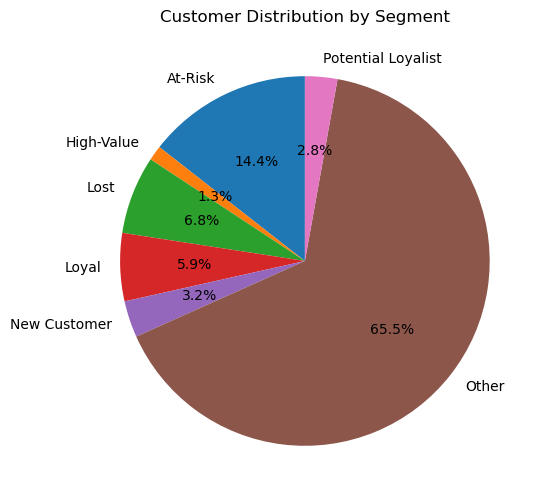

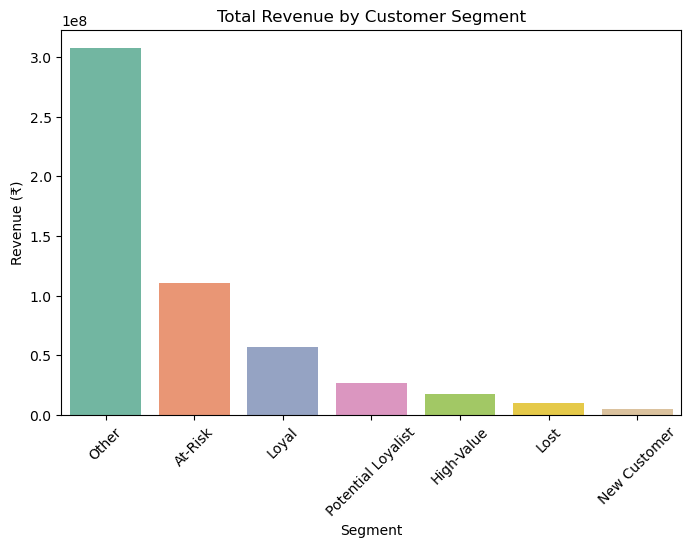

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pie chart: proportion of customers in each segment
plt.figure(figsize=(8,6))
plt.pie(segment_summary['Customer_Count'], labels=segment_summary['Segment'], autopct='%1.1f%%', startangle=90)
plt.title("Customer Distribution by Segment")
plt.show()

# Bar chart: total revenue by segment
plt.figure(figsize=(8,5))
sns.barplot(
    x='Segment',
    y='Total_Monetary',
    data=segment_summary.sort_values('Total_Monetary', ascending=False),
    hue='Segment',         # assign x variable to hue
    palette='Set2',
    legend=False           # hide redundant legend
)
plt.title("Total Revenue by Customer Segment")
plt.ylabel("Revenue (₹)")
plt.xticks(rotation=45)
plt.show()


2.5 Marketing & Engagement Recommendations

| Segment              | Recommended Strategy                                      |
| -------------------- | --------------------------------------------------------- |
| High-Value Customers | Loyalty programs, VIP deals, early access to new products |
| Loyal Customers      | Personalized recommendations, repeat purchase incentives  |
| Potential Loyalists  | Targeted promotions to increase recency and frequency     |
| At-Risk Customers    | Win-back emails, special discounts, reminders             |
| New Customers        | Nurturing campaigns to increase frequency and spending    |
| Lost Customers       | Special offers, surveys, or win-back campaigns            |


2.6 Save the Updated RFM Table with Segments

In [11]:
rfm_df.to_csv("rfm_customer_segments_final.csv", index=False)
print("Saved: rfm_customer_segments_final.csv")


Saved: rfm_customer_segments_final.csv


----------------------------------------------------------------------------------------------------------

Subtask 3: Visualize Customer Segments

3.1 Load RFM Data

In [12]:
import pandas as pd

# Load final RFM table
rfm_df = pd.read_csv("rfm_customer_segments_final.csv")

# Quick check
print(rfm_df.head())


           Customer Name  Recency  Frequency  Monetary  R_Score  F_Score  \
0  Aaina Balasubramanian      643          1  158876.8        1        1   
1         Aaina Bhargava       15          1   26411.9        5        1   
2              Aaina Bir      133          1  231044.0        5        1   
3          Aaina Chander      286          1  350240.0        4        1   
4         Aaina Chandran      572          1   43747.5        2        1   

   M_Score RFM_Segment Customer_Segment  
0        4       1-1-4            Other  
1        1       5-1-1     New Customer  
2        5       5-1-5            Other  
3        5       4-1-5            Other  
4        2       2-1-2             Lost  


3.2 Bar Chart: Customer Distribution by Segment

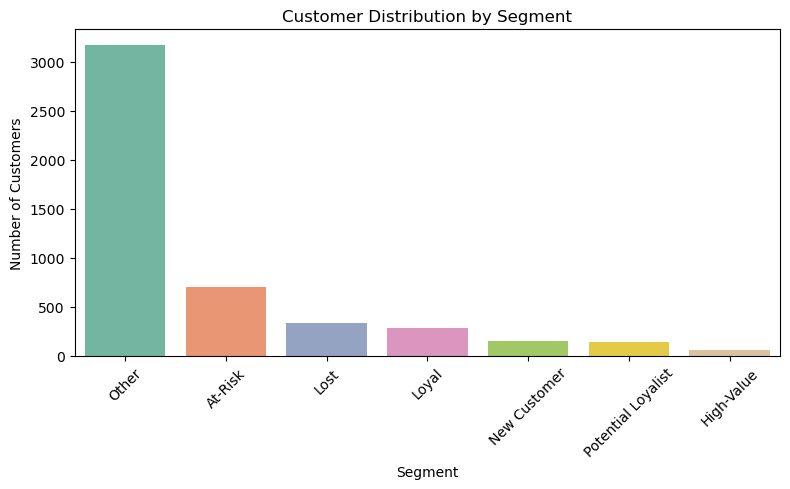

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare summary
segment_counts = rfm_df['Customer_Segment'].value_counts().reset_index()
segment_counts.columns = ['Segment','Customer_Count']

# Bar chart
plt.figure(figsize=(8,5))
sns.barplot(
    x='Segment',
    y='Customer_Count',
    data=segment_counts.sort_values('Customer_Count', ascending=False),
    hue='Segment',   # Fix for Seaborn v0.14 warning
    palette='Set2',
    legend=False
)
plt.title("Customer Distribution by Segment")
plt.ylabel("Number of Customers")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


3.3 Scatter / Bubble Plot: Recency vs Frequency vs Monetary

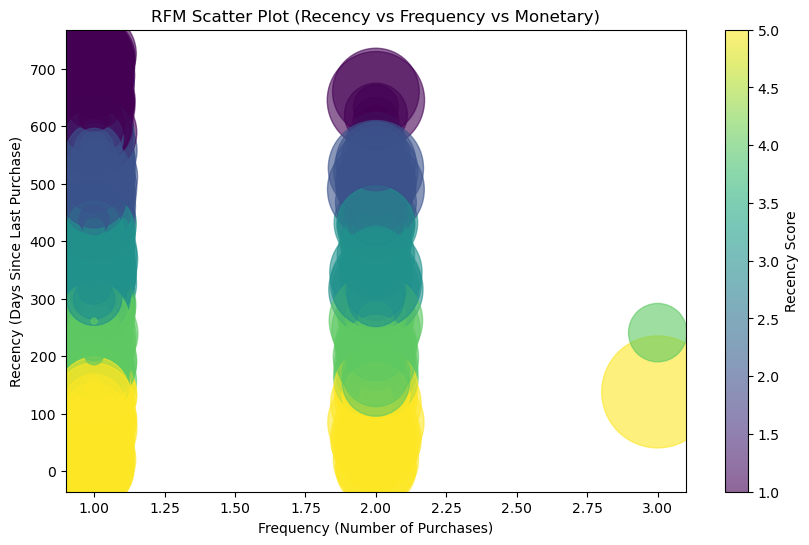

In [14]:
plt.figure(figsize=(10,6))
scatter = plt.scatter(
    rfm_df['Frequency'],
    rfm_df['Recency'],
    s=rfm_df['Monetary']/100,  # bubble size proportional to spending
    c=rfm_df['R_Score'],       # color represents Recency score
    cmap='viridis',
    alpha=0.6
)
plt.colorbar(scatter, label='Recency Score')
plt.xlabel("Frequency (Number of Purchases)")
plt.ylabel("Recency (Days Since Last Purchase)")
plt.title("RFM Scatter Plot (Recency vs Frequency vs Monetary)")
plt.show()


3.4 Heatmap: RFM Score Density

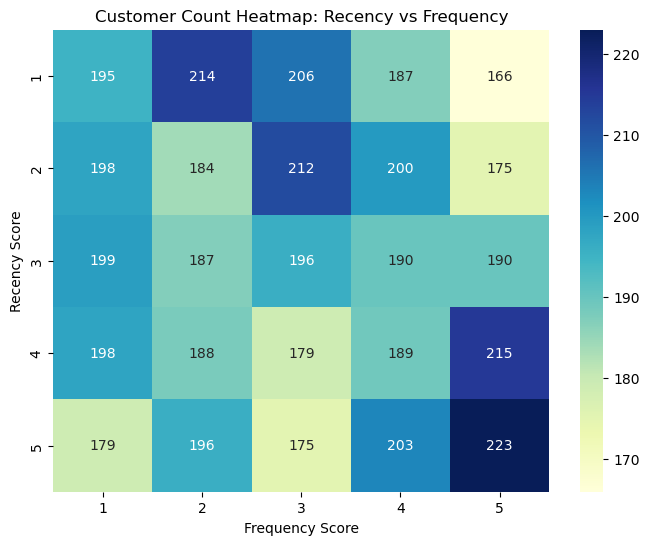

In [15]:
# Pivot table: count of customers per R-F score combination
rf_counts = rfm_df.groupby(['R_Score','F_Score']).size().unstack(fill_value=0)

plt.figure(figsize=(8,6))
sns.heatmap(rf_counts, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Customer Count Heatmap: Recency vs Frequency")
plt.xlabel("Frequency Score")
plt.ylabel("Recency Score")
plt.show()


3.5 Pie Chart: Customer Segment Proportions

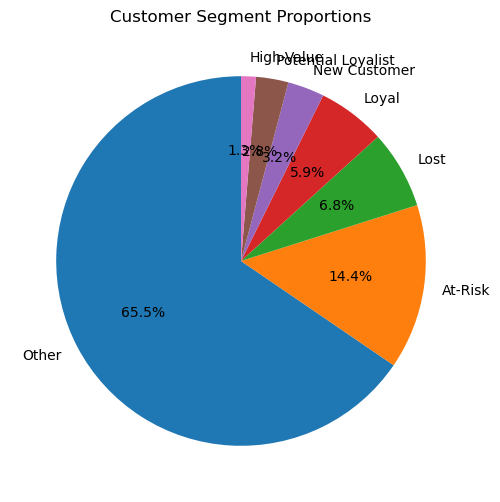

In [34]:
plt.figure(figsize=(6,6))
plt.pie(segment_counts['Customer_Count'], labels=segment_counts['Segment'], autopct='%1.1f%%', startangle=90)
plt.title("Customer Segment Proportions")
plt.show()


3.6 Document & Interpret Insights

1. Bar Chart Interpretation:
See which segment has the largest number of customers.
High-Value or Loyal Customers might be smaller but contribute more revenue.

2. Scatter Plot Interpretation:
Clusters show customer groups: active, high spenders, at-risk, etc.
Large bubbles in top-left (high frequency, low recency) = loyal, recently active customers.

3. Heatmap Interpretation:
Dense areas = segments that need targeted engagement.
Sparse cells = underrepresented combinations (opportunity to grow).

4. Pie Chart Interpretation:
Quick overview of customer distribution.
Helps prioritize marketing campaigns (focus on high-value and at-risk segments).